In [25]:
# Imports
import json
import os
import sys
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display

from sklearn import decomposition, manifold
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder

from PIL import Image, ImageDraw

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from torchvision.datasets.folder import is_image_file

from vit_pytorch import ViT

import mlflow
import mlflow.pytorch

from AACN_Model import attention_augmented_resnet18, attention_augmented_inceptionv3, attention_augmented_vgg19

In [26]:
# Setup device
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

In [27]:
# Data Preprocessing
date_list = [
    '04_11_21',
    '14_09_21',
    '14_09_22',
    '15_07_22',
    '25_05_22',
    '27_07_21'
]

In [28]:
# Set the base directory
base_dir = "/Users/izzymohamed/Desktop/Vision For Social Good/Project/Vision-For-Social-Good/DATA/Peach"

In [29]:
# Define main directories
base_dir = '/Users/izzymohamed/Desktop/Vision For Social Good/Project/Vision-For-Social-Good/DATA/Peach/'
date = date_list[0]
date_dir = os.path.join(base_dir, date)

In [30]:
# Load CSV data
multimodal_data_path = os.path.join(base_dir, "combined_multimodal_data.csv")
multimodal_df = pd.read_csv(multimodal_data_path)

In [31]:
multimodal_df.columns

Index(['Date', 'Tree_ID', 'Orchard_Mapping_Image', 'Aerial_UAV_Image',
       'Ground_RGB_Image', 'Ground_RGB_Image_with_Bounding_Boxes',
       'Ground_RGB_Image_Annotations', 'Multispectral_RGB_Image',
       'Multispectral_REG_Image', 'Multispectral_RED_Image',
       'Multispectral_NIR_Image', 'Multispectral_GRE_Image',
       'Multispectral_RGB_Bounding_Box_Image',
       'Multispectral_RGB_Bounding_Box_Annotation', 'Label', 'UAV_NDVI',
       'UAV_EVI', 'UAV_NDRE', 'UAV_SAVI', 'UAV_GNDVI', 'UAV_RVI', 'UAV_TVI',
       'x1', 'x2', 'y1', 'y2', 'Multispectral_NDVI', 'Multispectral_EVI',
       'Multispectral_NDRE', 'Multispectral_SAVI', 'Multispectral_GNDVI',
       'Multispectral_RVI', 'Multispectral_TVI', 'Multispectral_NDVI_Image',
       'Multispectral_GNDVI_Image', 'Multispectral_NDRE_Image',
       'Multispectral_SAVI_Image', 'date'],
      dtype='object')

In [32]:
# Feature columns
feature_columns = [
    'UAV_NDVI', 'UAV_EVI', 'UAV_NDRE', 'UAV_SAVI', 'UAV_GNDVI', 'UAV_RVI', 'UAV_TVI', 'Multispectral_SAVI',
    'Multispectral_NDVI', 'Multispectral_GNDVI', 'Multispectral_SAVI',
    'Multispectral_RVI', 'Multispectral_EVI', 'Multispectral_NDRE',
]
csv_features = multimodal_df[feature_columns].values.astype(np.float32)

In [33]:
# Create a mapping from class names to indices
classes = ['Healthy', 'Grapholita molesta', 'Anarsia lineatella', 'Dead Tree']
class_to_idx = {0: 0, 1: 1, 2: 2, 3: 3}

In [34]:
# Remove rows with label = 0
# multimodal_df = multimodal_df[multimodal_df['Label'] != 0]

In [35]:
# Define the models
num_classes_inception = 4  # Adjust this number based on your dataset
num_classes_others = 4  # Adjust this number based on your dataset

In [36]:
# Dataset class for CSV-only data
class CSVOnlyDataset(Dataset):
    def __init__(self, df, feature_columns, class_to_idx):
        self.df = df
        self.feature_columns = feature_columns
        self.class_to_idx = class_to_idx

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Extract features from the DataFrame
        csv_row = row[self.feature_columns].values.astype(np.float32)

        label_int = row['Label']
        label = self.class_to_idx[label_int]

        return torch.tensor(csv_row, dtype=torch.float32), label

In [37]:
# Split data into train, validation, and test sets directly from the CSV
train_df, test_df = train_test_split(multimodal_df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

In [38]:
# Initialize the datasets
train_dataset = CSVOnlyDataset(train_df, feature_columns, class_to_idx)
val_dataset = CSVOnlyDataset(val_df, feature_columns, class_to_idx)
test_dataset = CSVOnlyDataset(test_df, feature_columns, class_to_idx)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [39]:
# Define the Deep MLP CSV feature extractor
class MLPCSVFeatureExtractor(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=10):
        super(MLPCSVFeatureExtractor, self).__init__()
        layers = [nn.Linear(input_dim, hidden_dim), nn.ReLU()]
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
        self.extractor = nn.Sequential(*layers)

    def forward(self, x):
        return self.extractor(x)

In [40]:
# Define the Convolutional CSV feature extractor
class ConvCSVFeatureExtractor(nn.Module):
    def __init__(self, input_dim, hidden_dim, seq_len, num_layers=2):
        super(ConvCSVFeatureExtractor, self).__init__()
        self.num_layers = num_layers

        # Define the convolutional layers
        layers = [nn.Conv1d(in_channels=1, out_channels=hidden_dim, kernel_size=3, padding=1), nn.ReLU()]
        for _ in range(num_layers - 1):
            layers.append(nn.Conv1d(in_channels=hidden_dim, out_channels=hidden_dim, kernel_size=3, padding=1))
            layers.append(nn.ReLU())
        self.conv_layers = nn.Sequential(*layers)

        # Calculate the size of the output after the convolutions
        with torch.no_grad():
            dummy_input = torch.zeros(1, seq_len).unsqueeze(1)  # (batch_size=1, channels=1, seq_len)
            dummy_output = self.conv_layers(dummy_input)
            conv_output_size = dummy_output.view(1, -1).size(1)  # Flatten the output

        # Initialize the fully connected layer with the correct input size
        self.fc = nn.Linear(conv_output_size, hidden_dim)

    def forward(self, x):
        x = x.unsqueeze(1)  # Adding channel dimension for Conv1D
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc(x)
        return x

In [41]:
# Function to train the model
def train_model(csv_model_name, model, criterion, optimizer, train_loader, val_loader, num_classes, device, num_epochs=40, initial_lr=0.001, save_path = ''):
    early_stopping_patience = 5
    best_val_loss = float('inf')
    patience_counter = 0

    model.to(device)

    # Start an MLflow run
    with mlflow.start_run(run_name=csv_model_name):

        # Log parameters
        mlflow.log_param("csv_model_type", csv_model_name)
        mlflow.log_param("num_epochs", num_epochs)
        mlflow.log_param("learning_rate", initial_lr)

        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            correct = 0
            total = 0
            for data in train_loader:
                inputs_csv, labels = data
                inputs_csv, labels = inputs_csv.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(inputs_csv)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            train_loss = running_loss / len(train_loader)
            train_accuracy = 100 * correct / total

            # Validation
            model.eval()
            val_loss = 0.0
            correct = 0
            total = 0
            with torch.no_grad():
                for data in val_loader:
                    inputs_csv, labels = data
                    inputs_csv, labels = inputs_csv.to(device), labels.to(device)
                    outputs = model(inputs_csv)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            val_loss /= len(val_loader)
            val_accuracy = 100 * correct / total

            # Log metrics
            mlflow.log_metric("train_loss", train_loss, step=epoch)
            mlflow.log_metric("train_accuracy", train_accuracy, step=epoch)
            mlflow.log_metric("val_loss", val_loss, step=epoch)
            mlflow.log_metric("val_accuracy", val_accuracy, step=epoch)

            print(f'Epoch {epoch + 1}/{num_epochs}, '
                  f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
                  f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

            # Save the best checkpoint
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                checkpoint = {
                    'epoch': epoch + 1,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'best_val_loss': best_val_loss,
                    'train_loss': train_loss,
                    'val_loss': val_loss
                }
                torch.save(checkpoint, os.path.join(save_path, f'{csv_model_name}_model_checkpoint.pth'))
                print(f"Checkpoint saved to model_checkpoint.pth")
            else:
                patience_counter += 1
                # if patience_counter >= early_stopping_patience:
                #     print("Early stopping due to no improvement in validation loss.")
                #     break

        # Log the trained model
        mlflow.pytorch.log_model(model, f"{csv_model_name}_model")

    return model

In [42]:
def evaluate_model(model, test_loader, criterion, device, num_classes):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for data in test_loader:
            inputs_csv, labels = data
            inputs_csv, labels = inputs_csv.to(device), labels.to(device)
            outputs = model(inputs_csv)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_loss /= len(test_loader)
    test_accuracy = 100 * correct / total

    return test_loss, test_accuracy, all_predictions, all_labels

In [43]:
num_classes = len(class_to_idx)

In [44]:
# Clear cache function
def clear_cache():
    if torch.backends.mps.is_available():
        torch.mps.empty_cache()
    elif torch.cuda.is_available():
        torch.cuda.empty_cache()
    else:
        torch.cache.empty_cache()

In [45]:
class Tee(object):
    def __init__(self, *files):
        self.files = files

    def write(self, obj):
        for f in self.files:
            f.write(obj)
            f.flush()  # Make sure the output is written immediately

    def flush(self):
        for f in self.files:
            f.flush()

In [46]:
# Create a results folder
results_base_dir = "/Users/izzymohamed/Desktop/Vision For Social Good/Project/Vision-For-Social-Good/RESULTS/Single"
results_folder = os.path.join(results_base_dir,'Peach', 'CSV', 'T2')
os.makedirs(results_folder, exist_ok=True)

In [47]:
# Ensure csv_input_dim is defined based on the number of CSV features
csv_input_dim = len(feature_columns)
csv_hidden_dim = 256  # Define the hidden dimension size
seq_len = len(feature_columns)  # Sequence length for convolutional models

In [48]:
# Define the results dictionary to store model performance
crop_results = {}

# Open the file to save the train, validation, and test results
with open(os.path.join(results_base_dir, 'train_val_test_results.txt'), 'w') as f:
    for csv_model_type in ['mlp_small', 'mlp_medium', 'conv_small', 'conv_medium']:
        if csv_model_type.__contains__('mlp_small'):
            model = ConvCSVFeatureExtractor(csv_input_dim, csv_hidden_dim, seq_len, num_layers=25).to(device)
        else:
            model = MLPCSVFeatureExtractor(csv_input_dim, csv_hidden_dim, num_layers=50).to(device)

        print(f'\n\nTraining {csv_model_type} model...')
        f.write(f'\n\nTraining {csv_model_type} model...\n')

        # Train the model
        trained_model = train_model(
            csv_model_type,
            model,
            nn.CrossEntropyLoss().to(device),
            torch.optim.Adam(model.parameters(), lr=0.001),
            train_loader,
            val_loader,
            num_classes,
            device,
            num_epochs=40,
            initial_lr=0.001,
            save_path=results_base_dir
        )

        # Define all possible classes (this should match your classes list)
        all_classes = [0, 1, 2, 3]  # Adjust based on your class_to_idx mapping

        # Evaluate the model
        test_loss, test_accuracy, all_predictions, all_labels = evaluate_model(
            trained_model, test_loader, nn.CrossEntropyLoss(), device, num_classes
        )

        # Store results in the dictionary
        crop_results[csv_model_type] = {
            'model': trained_model,
            'test_loss': test_loss,
            'test_accuracy': test_accuracy,
            'classification_report': classification_report(
                all_labels,
                all_predictions,
                target_names=classes,  # Make sure 'classes' corresponds to the target names
                labels=all_classes,  # Specify all possible labels
                output_dict=True
            )
        }

        # Print and save the results
        result_summary = f'{csv_model_type} Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%\n'
        print(result_summary)
        print("\n")
        f.write(result_summary)

        # Save the classification report to a text file
        report = classification_report(all_labels, all_predictions, target_names=classes)
        with open(os.path.join(results_base_dir, f'{csv_model_type}_classification_report.txt'), 'w') as report_file:
            report_file.write(report)



Training mlp_small model...
Epoch 1/40, Train Loss: 0.5205, Train Accuracy: 95.31%, Val Loss: 0.1985, Val Accuracy: 96.15%
Checkpoint saved to model_checkpoint.pth
Epoch 2/40, Train Loss: 0.2038, Train Accuracy: 96.25%, Val Loss: 0.1925, Val Accuracy: 96.15%
Checkpoint saved to model_checkpoint.pth
Epoch 3/40, Train Loss: 0.1982, Train Accuracy: 96.25%, Val Loss: 0.1939, Val Accuracy: 96.15%
Epoch 4/40, Train Loss: 0.1987, Train Accuracy: 96.25%, Val Loss: 0.1944, Val Accuracy: 96.15%
Epoch 5/40, Train Loss: 0.2051, Train Accuracy: 96.25%, Val Loss: 0.2056, Val Accuracy: 96.15%
Epoch 6/40, Train Loss: 0.2037, Train Accuracy: 96.25%, Val Loss: 0.2010, Val Accuracy: 96.15%
Epoch 7/40, Train Loss: 0.2005, Train Accuracy: 96.25%, Val Loss: 0.2056, Val Accuracy: 96.15%
Epoch 8/40, Train Loss: 0.2000, Train Accuracy: 96.25%, Val Loss: 0.1945, Val Accuracy: 96.15%
Epoch 9/40, Train Loss: 0.1981, Train Accuracy: 96.25%, Val Loss: 0.2027, Val Accuracy: 96.15%
Epoch 10/40, Train Loss: 0.1988, 

2024/08/21 21:05:44 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1

mlp_small Test Loss: 0.2405, Test Accuracy: 95.03%





Training mlp_medium model...
Epoch 1/40, Train Loss: 5.5457, Train Accuracy: 74.19%, Val Loss: 5.5452, Val Accuracy: 96.15%
Checkpoint saved to model_checkpoint.pth
Epoch 2/40, Train Loss: 5.5452, Train Accuracy: 96.25%, Val Loss: 5.5452, Val Accuracy: 96.15%
Epoch 3/40, Train Loss: 5.5452, Train Accuracy: 96.25%, Val Loss: 5.5452, Val Accuracy: 96.15%
Epoch 4/40, Train Loss: 5.5452, Train Accuracy: 96.25%, Val Loss: 5.5452, Val Accuracy: 96.15%
Epoch 5/40, Train Loss: 5.5452, Train Accuracy: 96.25%, Val Loss: 5.5452, Val Accuracy: 96.15%
Epoch 6/40, Train Loss: 5.5452, Train Accuracy: 96.25%, Val Loss: 5.5452, Val Accuracy: 96.15%
Epoch 7/40, Train Loss: 5.5452, Train Accuracy: 96.25%, Val Loss: 5.5452, Val Accuracy: 96.15%
Epoch 8/40, Train Loss: 5.5452, Train Accuracy: 96.25%, Val Loss: 5.5452, Val Accuracy: 96.15%
Epoch 9/40, Train Loss: 5.5452, Train Accuracy: 96.25%, Val Loss: 5.5452, Val Accuracy: 96.15%
Epoch 10/40, Train 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/_distutils_hack/__init__.py:17: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/_distutils_hack/__init__.py:32: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
2024/08/21 21:08:42 WARNING mlflow.models.model: Input example should be provided t

mlp_medium Test Loss: 5.5452, Test Accuracy: 95.03%





Training conv_small model...
Epoch 1/40, Train Loss: 5.5457, Train Accuracy: 77.85%, Val Loss: 5.5452, Val Accuracy: 96.15%
Checkpoint saved to model_checkpoint.pth
Epoch 2/40, Train Loss: 5.5452, Train Accuracy: 96.25%, Val Loss: 5.5452, Val Accuracy: 96.15%
Epoch 3/40, Train Loss: 5.5452, Train Accuracy: 96.25%, Val Loss: 5.5452, Val Accuracy: 96.15%
Epoch 4/40, Train Loss: 5.5452, Train Accuracy: 96.25%, Val Loss: 5.5452, Val Accuracy: 96.15%
Epoch 5/40, Train Loss: 5.5452, Train Accuracy: 96.25%, Val Loss: 5.5452, Val Accuracy: 96.15%
Epoch 6/40, Train Loss: 5.5452, Train Accuracy: 96.25%, Val Loss: 5.5452, Val Accuracy: 96.15%
Epoch 7/40, Train Loss: 5.5452, Train Accuracy: 96.25%, Val Loss: 5.5452, Val Accuracy: 96.15%
Epoch 8/40, Train Loss: 5.5452, Train Accuracy: 96.25%, Val Loss: 5.5452, Val Accuracy: 96.15%
Epoch 9/40, Train Loss: 5.5452, Train Accuracy: 96.25%, Val Loss: 5.5452, Val Accuracy: 96.15%
Epoch 10/40, Train

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/_distutils_hack/__init__.py:17: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/_distutils_hack/__init__.py:32: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
2024/08/21 21:11:42 WARNING mlflow.models.model: Input example should be provided t

conv_small Test Loss: 5.5452, Test Accuracy: 95.03%





Training conv_medium model...
Epoch 1/40, Train Loss: 0.9695, Train Accuracy: 94.34%, Val Loss: 0.3440, Val Accuracy: 96.15%
Checkpoint saved to model_checkpoint.pth
Epoch 2/40, Train Loss: 0.3291, Train Accuracy: 96.25%, Val Loss: 0.3517, Val Accuracy: 96.15%
Epoch 3/40, Train Loss: 0.3177, Train Accuracy: 96.25%, Val Loss: 0.3300, Val Accuracy: 96.15%
Checkpoint saved to model_checkpoint.pth
Epoch 4/40, Train Loss: 0.3497, Train Accuracy: 96.25%, Val Loss: 0.3399, Val Accuracy: 96.15%
Epoch 5/40, Train Loss: 0.3221, Train Accuracy: 96.25%, Val Loss: 0.3367, Val Accuracy: 96.15%
Epoch 6/40, Train Loss: 0.3183, Train Accuracy: 96.25%, Val Loss: 0.3312, Val Accuracy: 96.15%
Epoch 7/40, Train Loss: 0.3240, Train Accuracy: 96.25%, Val Loss: 0.3226, Val Accuracy: 96.15%
Checkpoint saved to model_checkpoint.pth
Epoch 8/40, Train Loss: 0.3178, Train Accuracy: 96.25%, Val Loss: 0.3233, Val Accuracy: 96.15%
Epoch 9/40, Train Loss: 0.3188

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/_distutils_hack/__init__.py:17: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/_distutils_hack/__init__.py:32: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
2024/08/21 21:14:37 WARNING mlflow.models.model: Input example should be provided t

conv_medium Test Loss: 0.3537, Test Accuracy: 95.03%





/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

# Display Results

In [49]:
# Function to save figures
def save_figure(fig, filename):
    fig.savefig(os.path.join(results_folder, filename))
    plt.close(fig)

In [50]:
# List of classes
classes = ["Anarsia lineatella", "Grapholita molesta", "Dead Trees", "Healthy"]

### Accuracy Comparision

In [51]:
# Plot comparison of accuracy for each model
def plot_accuracy_comparison(results):
    accuracies = [result['test_accuracy'] for result in results.values()]  # Convert accuracy to percentage
    model_names = list(results.keys())

    fig = plt.figure(figsize=(20, 10))
    plt.bar(model_names, accuracies)
    plt.ylabel('Accuracy (%)')
    plt.xlabel('Model')
    plt.show()
    save_figure(fig, 'accuracy_comparison.png')

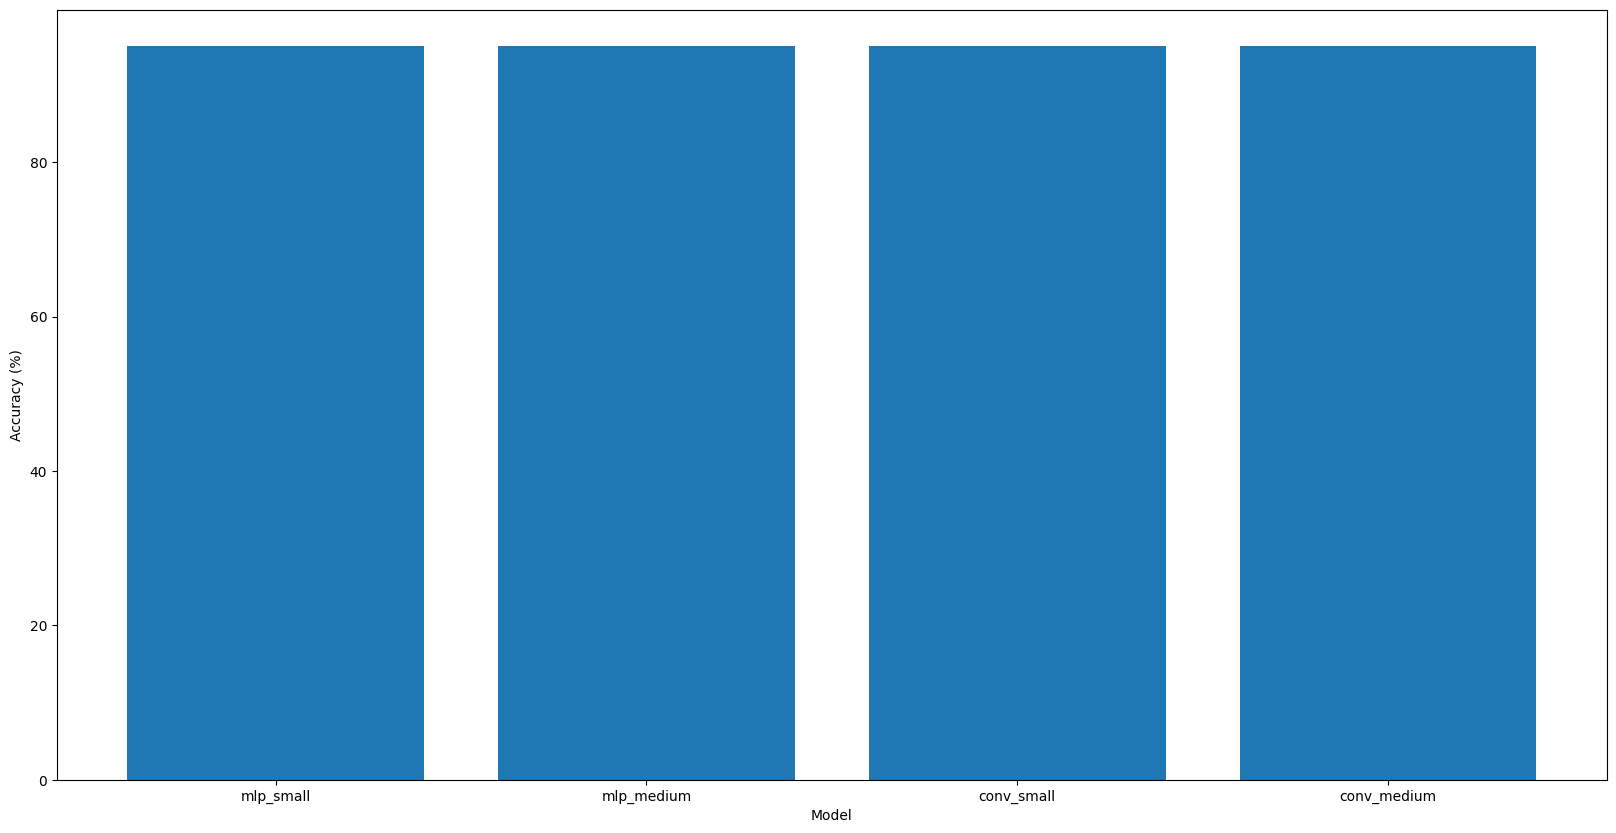

In [52]:
# Plot comparison of accuracy for each model for each crop
plot_accuracy_comparison(crop_results)

### Metrics Table

In [53]:
# Function to display F1, precision, and recall of all models as a table
def display_model_metrics_table(results, test_loader):
    metrics_data = []
    
    for model_name, model_info in results.items():
        if 'model' not in model_info:
            raise KeyError(f"The key 'model' is missing in the model_info for {model_name}.")
        
        model = model_info['model']
        device = next(model.parameters()).device  # Get the device of the model
        model.eval()  # Set the model to evaluation mode

        all_labels = []
        all_predicted = []

        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            with torch.no_grad():
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_predicted.extend(predicted.cpu().numpy())

        precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predicted, average='macro')
        
        metrics_data.append({
            'Model': model_name,
            'Precision': precision,
            'Recall': recall,
            'F1-score': f1
        })

    metrics_df = pd.DataFrame(metrics_data)
    display(metrics_df)  # Display the DataFrame in Jupyter Notebook
    metrics_df.to_csv(os.path.join(results_folder, 'model_metrics.csv'), index=False)

In [54]:
display_model_metrics_table(crop_results, test_loader)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

,Model,Precision,Recall,F1-score
0,mlp_small,0.23757,0.25,0.243627
1,mlp_medium,0.23757,0.25,0.243627
2,conv_small,0.23757,0.25,0.243627
3,conv_medium,0.23757,0.25,0.243627


### Classification Results

In [55]:
# Display some correctly and incorrectly classified images with confidence levels
def display_classification_results(model_name, model, test_loader, class_labels, num_images=5):
    model.eval()  # Set the model to evaluation mode
    device = next(model.parameters()).device  # Get the device of the model

    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)

    # Debugging: Print the shape of the images tensor
    print(f"Shape of images tensor: {images.shape}")

    if len(images.shape) != 4 or images.shape[1] != 3:
        raise ValueError(f"Expected images of shape (batch_size, 3, H, W), but got {images.shape}")

    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        ax = axes[i]
        img = images[i].cpu().numpy()
        
        # Debugging: Print the shape of the individual image tensor
        print(f"Shape of individual image tensor before transpose: {img.shape}")
        
        if img.shape[0] == 3:  # Check if the first dimension is channels
            img = img.transpose((1, 2, 0))  # Move tensor back to CPU for visualization
        else:
            raise ValueError(f"Unexpected image shape: {img.shape}")

        img = np.clip(img, 0, 1)
        ax.imshow(img)
        ax.set_title(f"Pred: {class_labels[predicted[i]]}\nTrue: {class_labels[labels[i]]}")
        ax.axis('off')

    plt.show()

In [56]:
# Display results for each model
# for model_name in crop_results.keys():
#     print(f'Displaying results for {model_name}')
#     display_classification_results(model_name, crop_results[model_name]['model'], test_loader, classes)

### Classification Report

In [57]:
# Function to display the classification report of a given model
def display_classification_report(model, test_loader, model_name, class_labels):
    device = next(model.parameters()).device  # Get the device of the model
    model.eval()  # Set the model to evaluation mode
    
    all_labels = []
    all_predicted = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predicted.extend(predicted.cpu().numpy())
    
    report = classification_report(all_labels, all_predicted, target_names=class_labels)
    
    print(report)
    
    results_folder = 'results'  # Define your results folder
    os.makedirs(results_folder, exist_ok=True)
    report_filename = os.path.join(results_folder, f'{model_name}_classification_report.txt')
    
    with open(report_filename, 'w') as f:
        f.write(report)
        

In [58]:
# Display results for each crop
for model_name in crop_results.keys():
    print(f'Displaying classification report for {model_name}')
    display_classification_report(crop_results[model_name]['model'], test_loader, model_name, ["Anarsia lineatella", "Grapholita molesta", "Dead Trees", "Healthy"])

Displaying classification report for mlp_small


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

                    precision    recall  f1-score   support

Anarsia lineatella       0.95      1.00      0.97      1013
Grapholita molesta       0.00      0.00      0.00        29
        Dead Trees       0.00      0.00      0.00        19
           Healthy       0.00      0.00      0.00         5

          accuracy                           0.95      1066
         macro avg       0.24      0.25      0.24      1066
      weighted avg       0.90      0.95      0.93      1066

Displaying classification report for mlp_medium


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

                    precision    recall  f1-score   support

Anarsia lineatella       0.95      1.00      0.97      1013
Grapholita molesta       0.00      0.00      0.00        29
        Dead Trees       0.00      0.00      0.00        19
           Healthy       0.00      0.00      0.00         5

          accuracy                           0.95      1066
         macro avg       0.24      0.25      0.24      1066
      weighted avg       0.90      0.95      0.93      1066

Displaying classification report for conv_small


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

                    precision    recall  f1-score   support

Anarsia lineatella       0.95      1.00      0.97      1013
Grapholita molesta       0.00      0.00      0.00        29
        Dead Trees       0.00      0.00      0.00        19
           Healthy       0.00      0.00      0.00         5

          accuracy                           0.95      1066
         macro avg       0.24      0.25      0.24      1066
      weighted avg       0.90      0.95      0.93      1066

Displaying classification report for conv_medium
                    precision    recall  f1-score   support

Anarsia lineatella       0.95      1.00      0.97      1013
Grapholita molesta       0.00      0.00      0.00        29
        Dead Trees       0.00      0.00      0.00        19
           Healthy       0.00      0.00      0.00         5

          accuracy                           0.95      1066
         macro avg       0.24      0.25      0.24      1066
      weighted avg       0.90      0.95      0

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

### Incorrect Predictions

In [59]:
# Function to normalize images
def normalize_image(image):
    image = image - image.min()
    image = image / image.max()
    return image

In [60]:
# Function to plot the most incorrect predictions with confidence levels
def plot_most_incorrect(incorrect, classes, n_images, model_name, normalize=True):
    rows = int(np.ceil(np.sqrt(n_images)))
    cols = int(np.ceil(n_images / rows))

    fig = plt.figure(figsize=(25, 20))

    for i in range(rows * cols):
        if i >= len(incorrect):
            break
        ax = fig.add_subplot(rows, cols, i + 1)
        image, true_label, probs = incorrect[i]
        image = image.permute(1, 2, 0)
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim=0)
        true_class = classes[true_label]
        incorrect_class = classes[incorrect_label]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.cpu().numpy())
        ax.set_title(f'True: {true_class} ({true_prob:.3f})\n'
                     f'Pred: {incorrect_class} ({incorrect_prob:.3f})\n'
                     f'Confidence: {incorrect_prob.item():.2f}', fontsize=10)
        ax.axis('off')

    plt.tight_layout()
    fig.subplots_adjust(hspace=0.7)
    plt.show()
    save_figure(fig, f'{model_name}_most_incorrect.png')

def get_all_details(model, test_loader):
    all_labels = []
    all_preds = []
    all_probs = []
    all_images = []
    device = next(model.parameters()).device  # Get the device of the model
    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            probs = F.softmax(outputs, dim=1)

            all_images.extend(images.cpu())
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu())

    return all_images, all_labels, all_preds, all_probs

# Define the number of images to display
N_IMAGES = 36

# Use this function to get the details
def plot_most_incorrect_predictions(results, test_loader, class_labels, n_images=36):
    for model_name, model_info in results.items():
        model = model_info['model']
        images, labels, pred_labels, probs = get_all_details(model, test_loader)
        corrects = torch.eq(torch.tensor(labels), torch.tensor(pred_labels))
        incorrect_examples = []

        for image, label, prob, correct in zip(images, labels, probs, corrects):
            if not correct:
                incorrect_examples.append((image, label, prob))

    incorrect_examples.sort(key=lambda x: torch.max(x[2], dim=0)[0], reverse=True)
    plot_most_incorrect(incorrect_examples[:n_images], class_labels, n_images, model_name)

In [61]:
# plot_most_incorrect_predictions(crop_results, test_loader, classes, N_IMAGES)

### Confusion Matrix

In [62]:
# Function to plot the confusion matrix with confidence levels
def plot_confusion_matrix_with_confidence(model, test_loader, class_labels, model_name):
    device = next(model.parameters()).device  # Get the device of the model
    model.eval()  # Set the model to evaluation mode

    all_labels = []
    all_predicted = []
    all_confidences = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probabilities = F.softmax(outputs, dim=1)
            confidence, predicted = torch.max(probabilities, 1)

            all_labels.extend(labels.cpu().numpy())
            all_predicted.extend(predicted.cpu().numpy())
            all_confidences.extend(confidence.cpu().numpy())

    # Compute the confusion matrix
    cm = confusion_matrix(all_labels, all_predicted)

    # Calculate the average confidence for each cell in the confusion matrix
    confidence_matrix = np.zeros_like(cm, dtype=float)

    for true_label in range(len(class_labels)):
        for pred_label in range(len(class_labels)):
            # Get indices where true_label and pred_label match
            indices = [i for i, (t, p) in enumerate(zip(all_labels, all_predicted)) if t == true_label and p == pred_label]
            if indices:
                avg_confidence = np.mean([all_confidences[i] for i in indices])
                confidence_matrix[true_label, pred_label] = avg_confidence

    # Plot the confusion matrix
    fig, ax = plt.subplots(figsize=(10, 10))
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    cm_display.plot(cmap='Blues', ax=ax, values_format='d')

    # Add the confidence level to each cell
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, f"\n{confidence_matrix[i, j]:.2f}", ha='center', va='center', color='red', fontsize=10)

    plt.xticks(rotation=45)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'{model_name} - Confusion Matrix with Confidence Levels')
    plt.show()

    # Save the figure
    save_figure(fig, f'{model_name}_confusion_matrix_with_confidence.png')

Generating confusion matrix with confidence for mlp_small


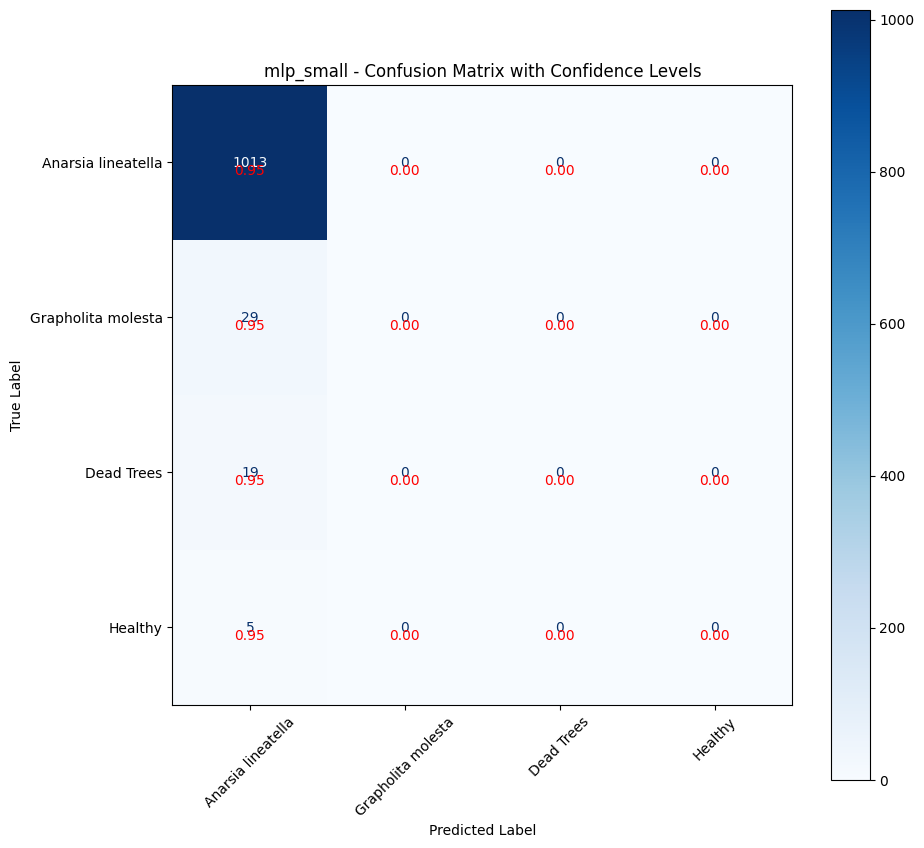

Generating confusion matrix with confidence for mlp_medium


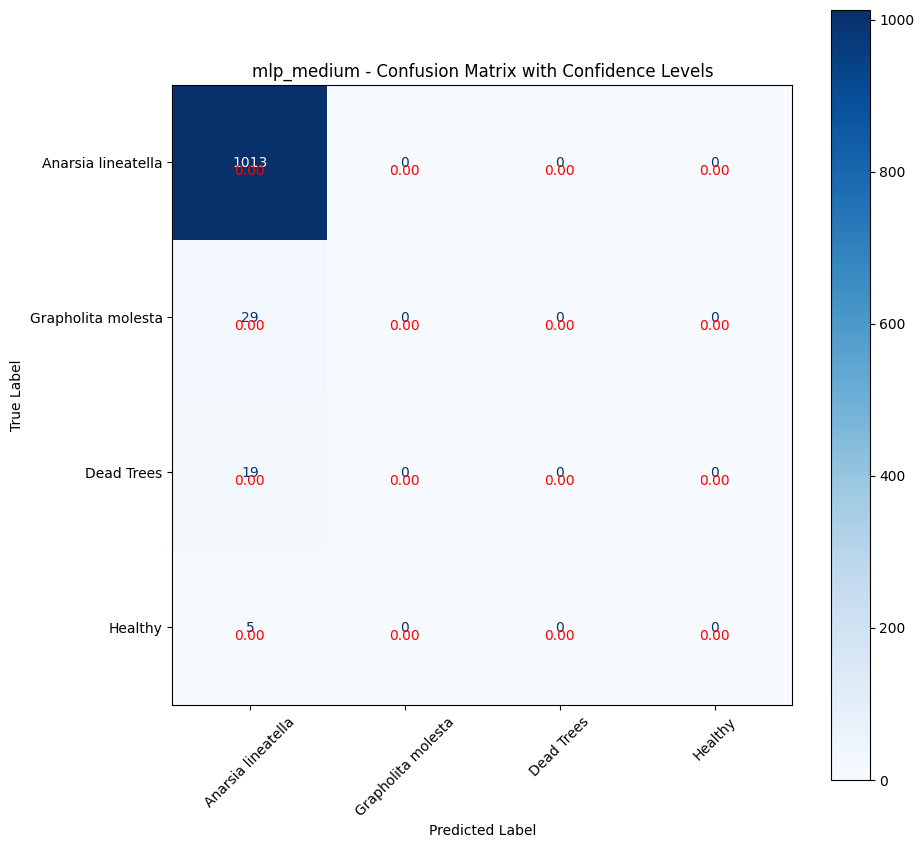

Generating confusion matrix with confidence for conv_small


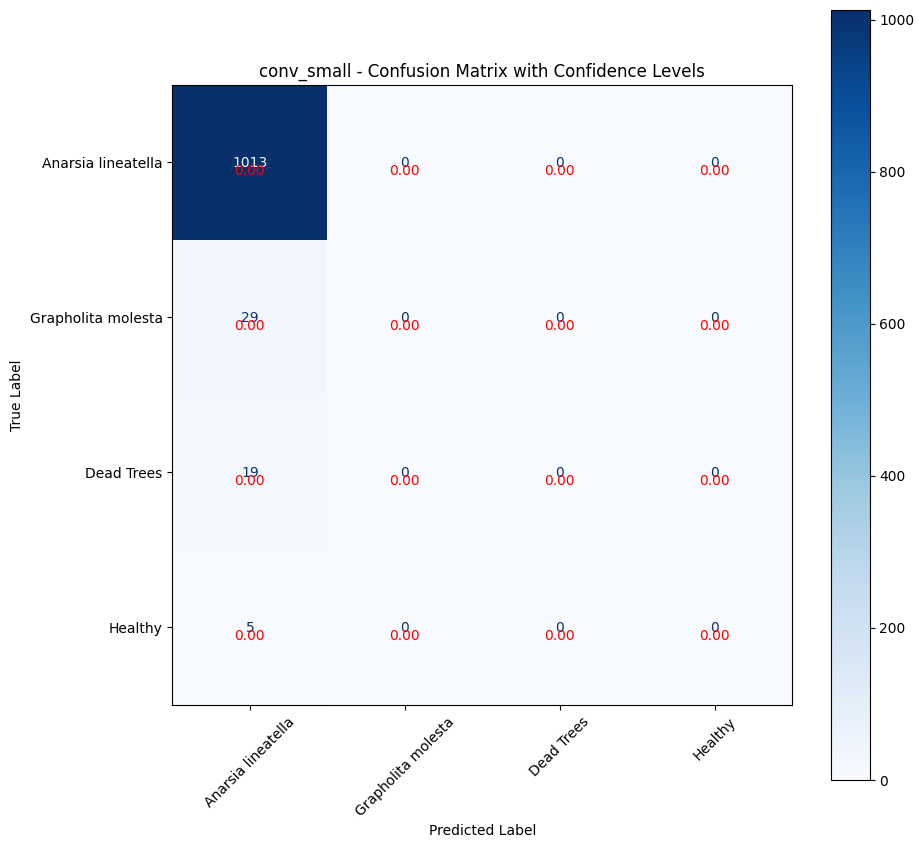

Generating confusion matrix with confidence for conv_medium


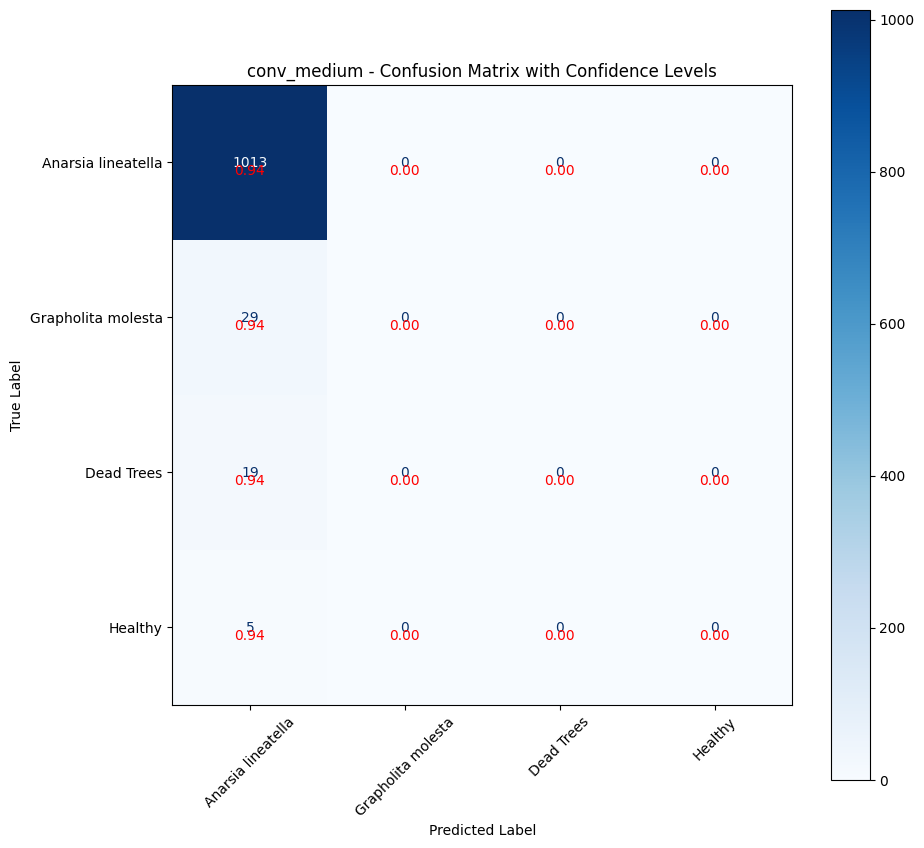

In [63]:
# Example usage for a single model:
for model_name in crop_results.keys():
    print(f'Generating confusion matrix with confidence for {model_name}')
    plot_confusion_matrix_with_confidence(crop_results[model_name]['model'], test_loader, classes, model_name)

### Representations and Dimensionality Reduction

In [64]:

def get_representations(model, iterator):
    model.eval()
    outputs = []
    labels = []

    with torch.no_grad():
        for x, y in iterator:
            x = x.to(device)
            y_pred = model(x)
            outputs.append(y_pred.cpu())
            labels.append(y)

    outputs = torch.cat(outputs, dim=0)
    labels = torch.cat(labels, dim=0)
    return outputs, labels

In [65]:
def get_pca(data, n_components=2):
    pca = decomposition.PCA(n_components=n_components)
    pca_data = pca.fit_transform(data)
    return pca_data

In [66]:
def plot_representations(data, labels, classes, n_images=None):
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]

    fig = plt.figure(figsize=(15, 15))
    # fig.suptitle(f'{model_name} - PCA', fontsize=28, y=0.95)
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c=labels, cmap='hsv')
    plt.show()
    save_figure(fig, f'{model_name}_pca.png')

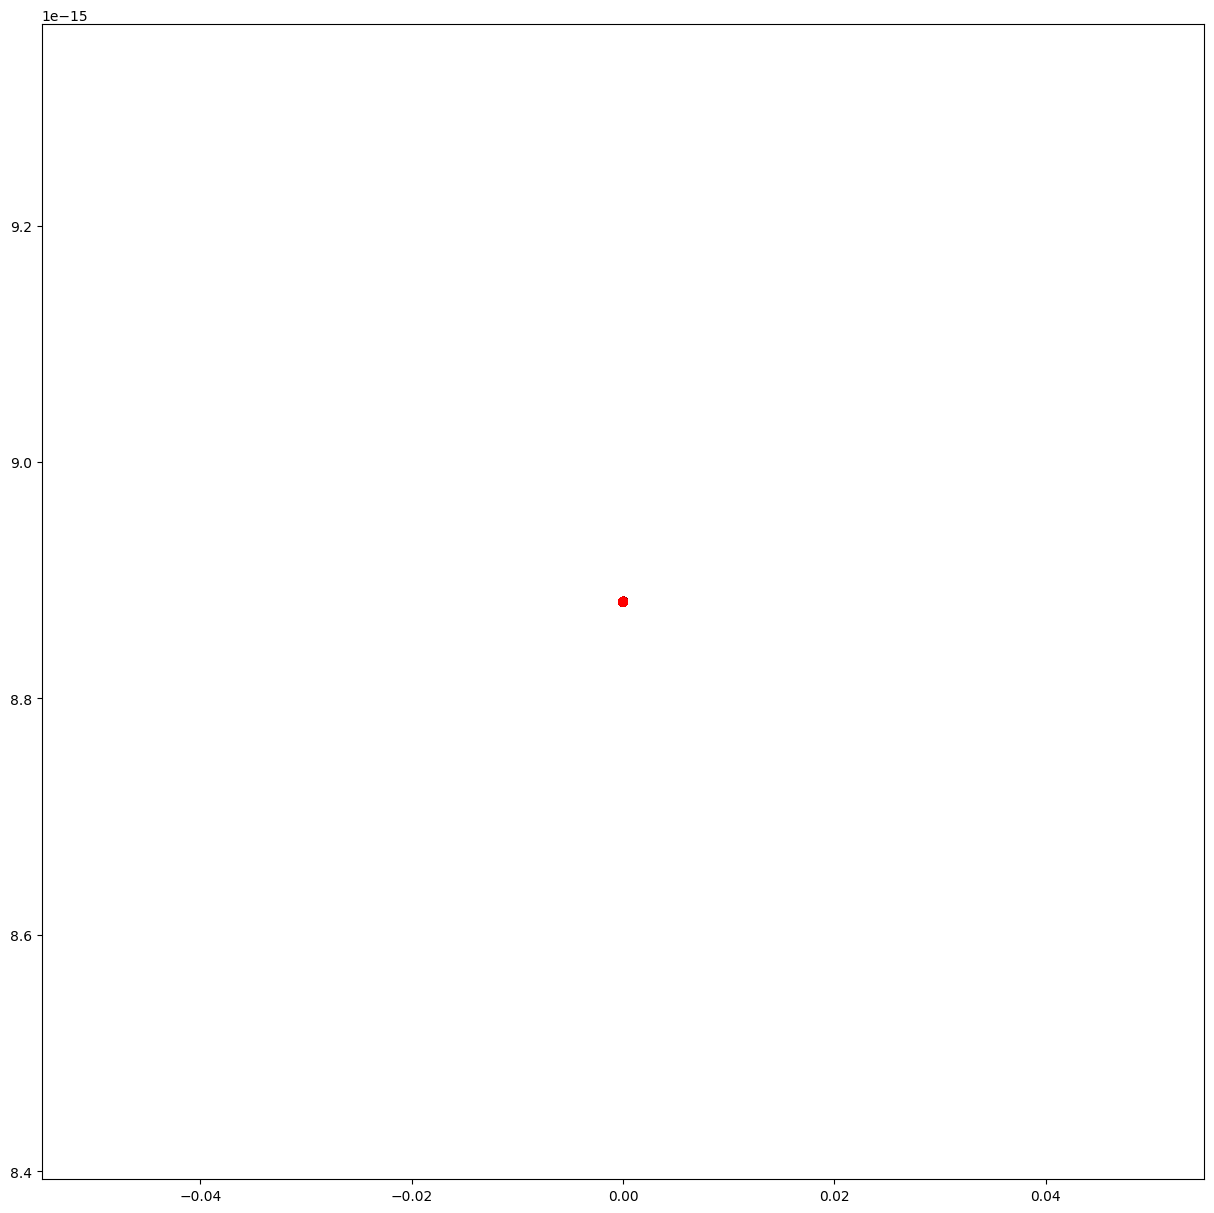

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/decomposition/_pca.py:652: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var


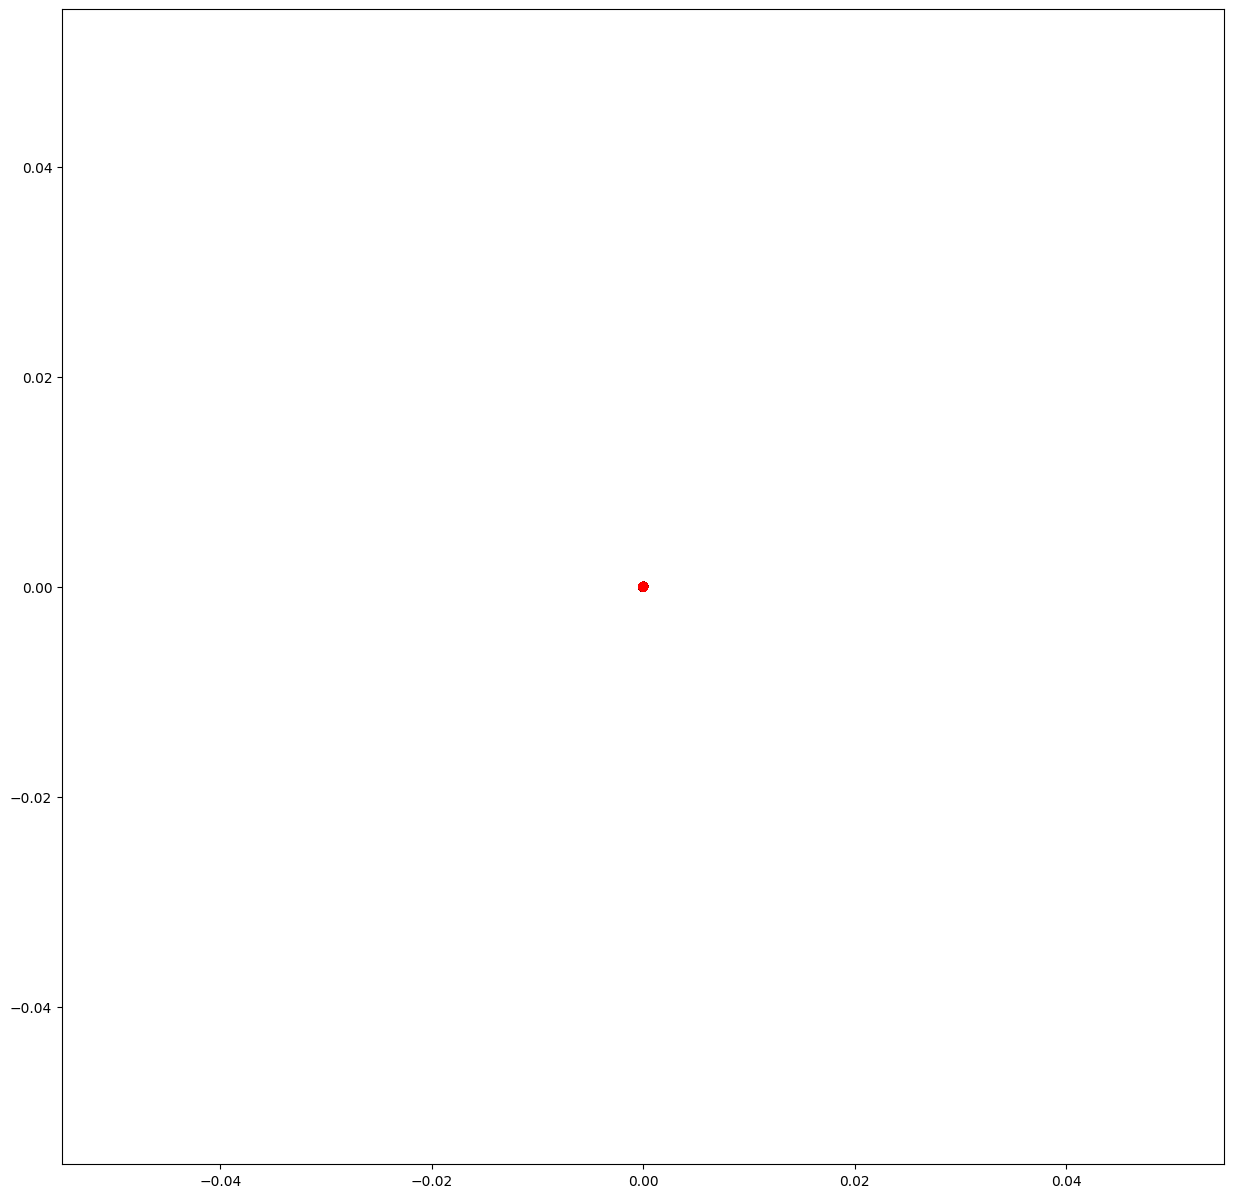

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/decomposition/_pca.py:652: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var


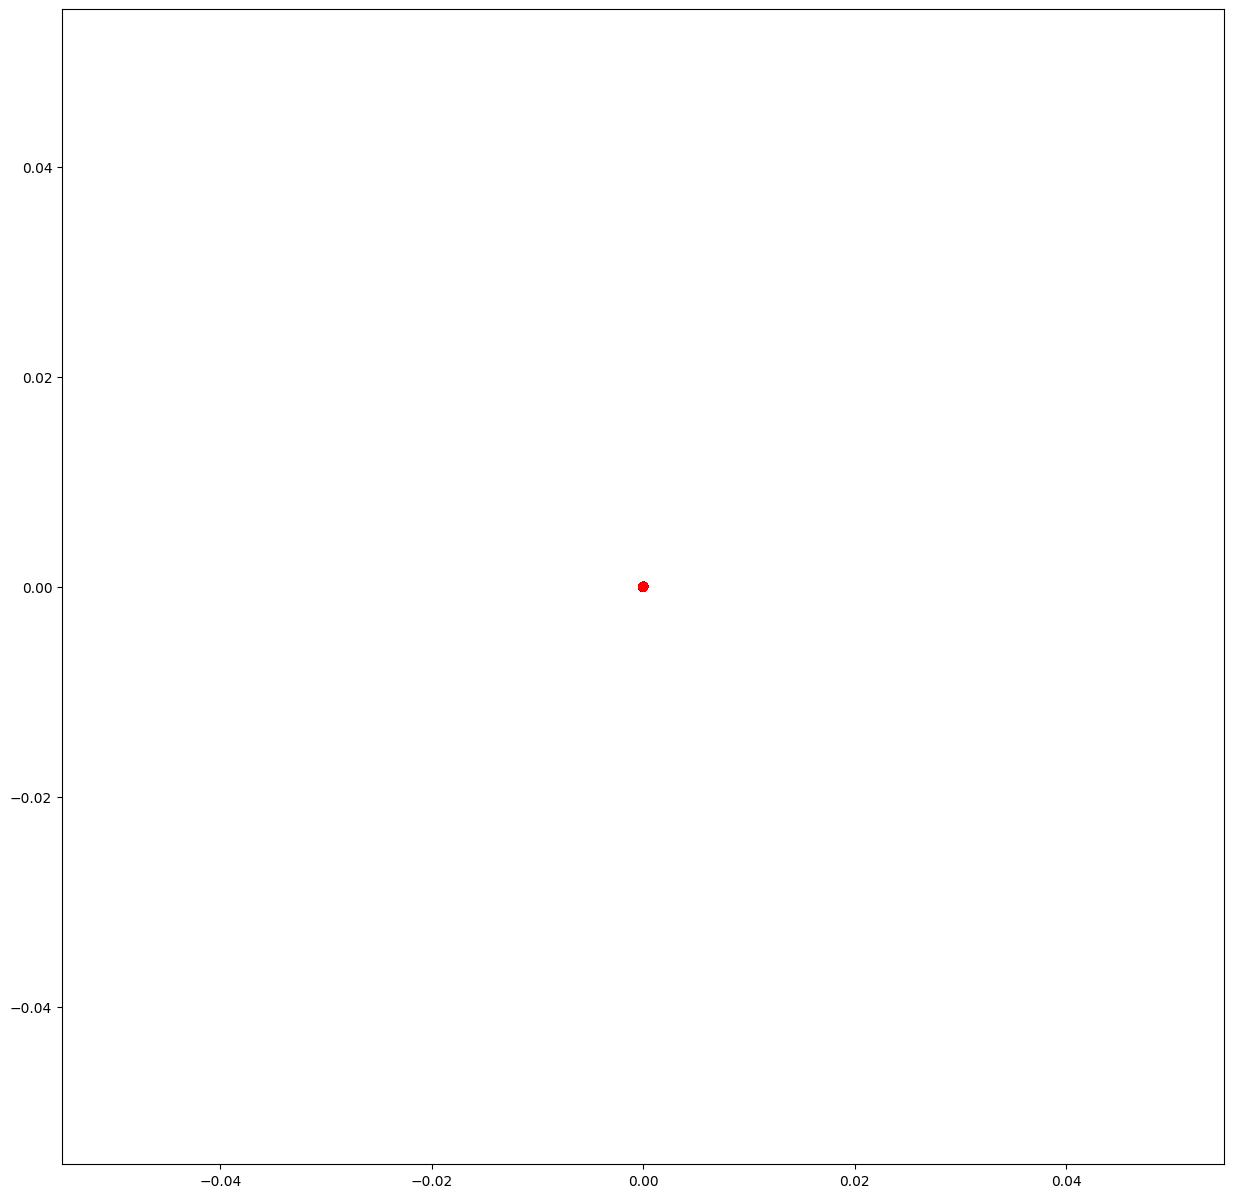

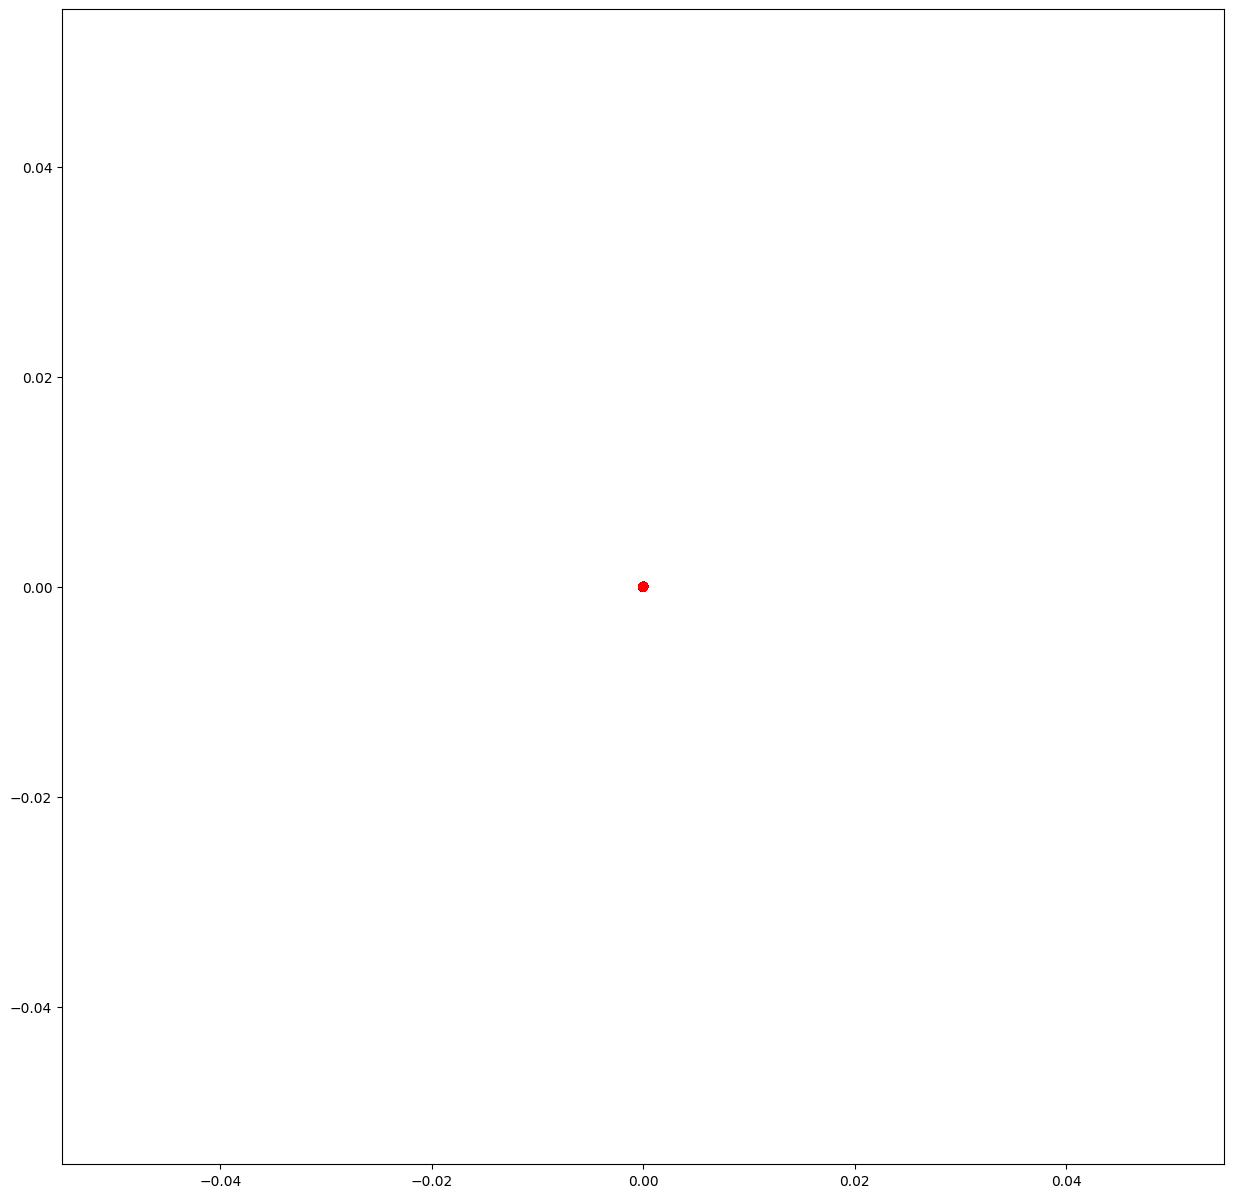

In [67]:
# Get representations for each model
for model in crop_results.values():
    outputs, labels = get_representations(model['model'], train_loader)
    output_pca_data = get_pca(outputs)
    plot_representations(output_pca_data, labels, classes)  # Adjusted to pass only three arguments

In [68]:
def get_tsne(data, n_components=2, n_images=None):
    if n_images is not None:
        data = data[:n_images]
    tsne = manifold.TSNE(n_components=n_components, random_state=0)
    tsne_data = tsne.fit_transform(data)
    return tsne_data

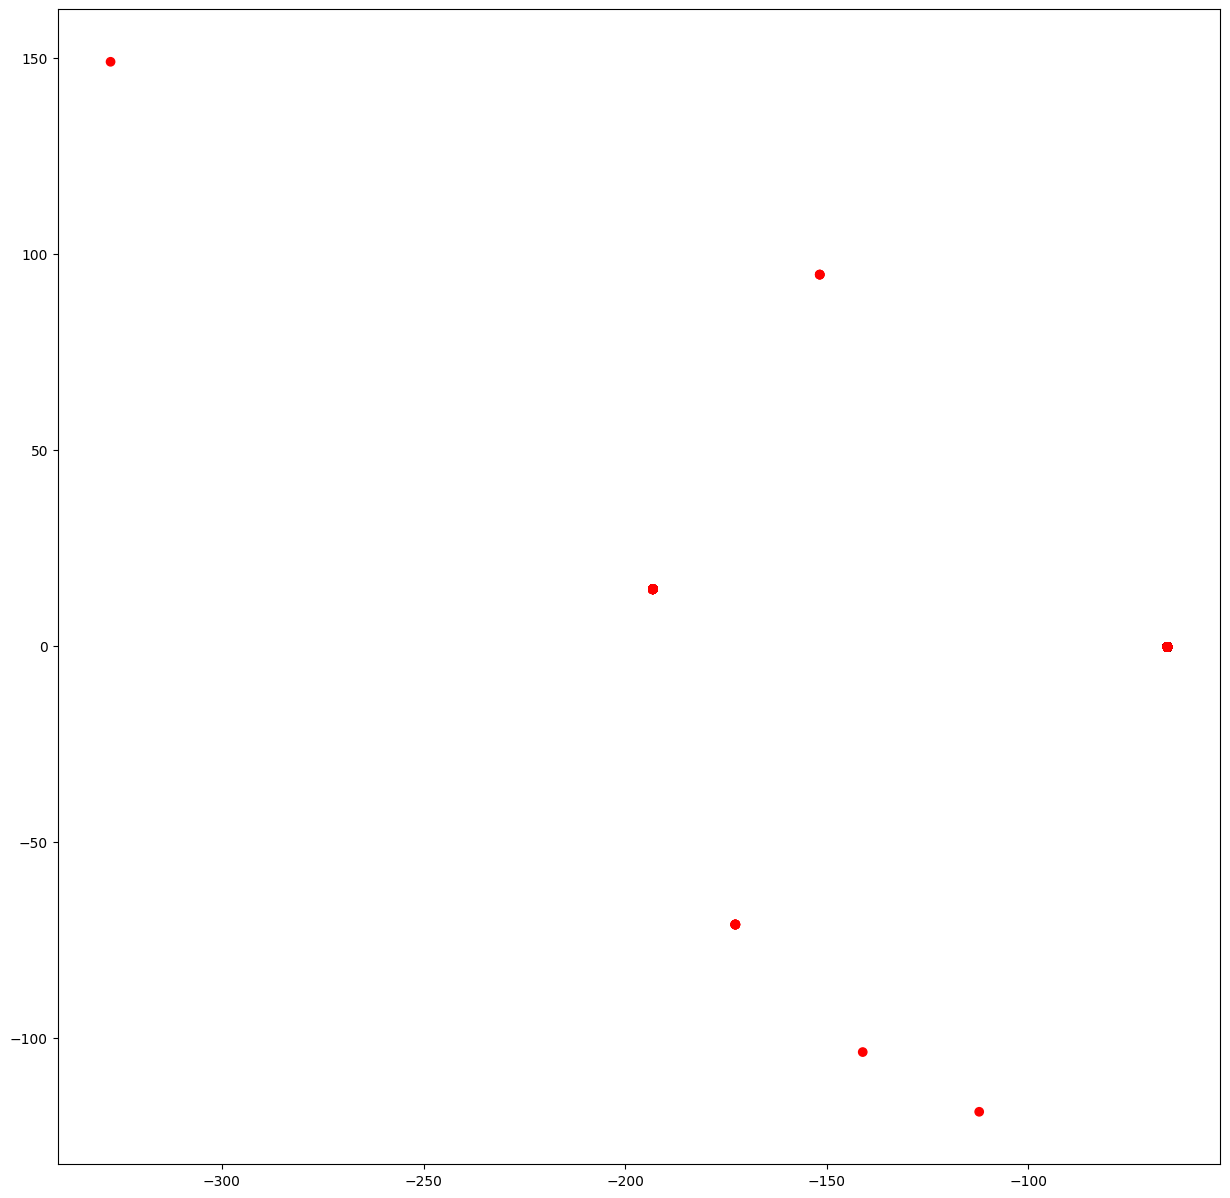

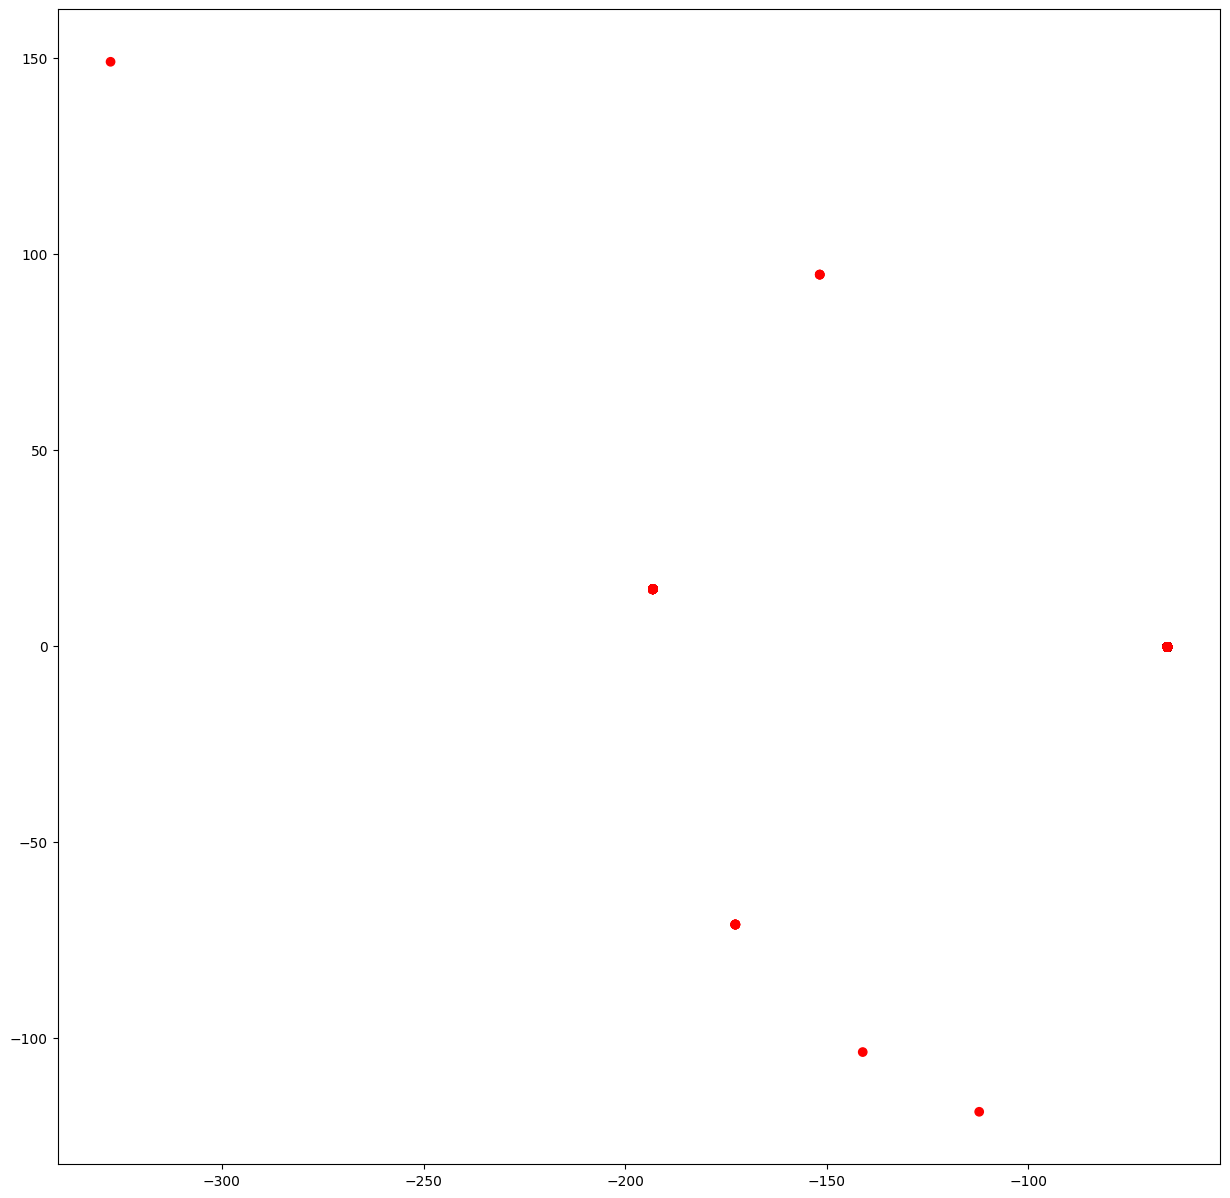

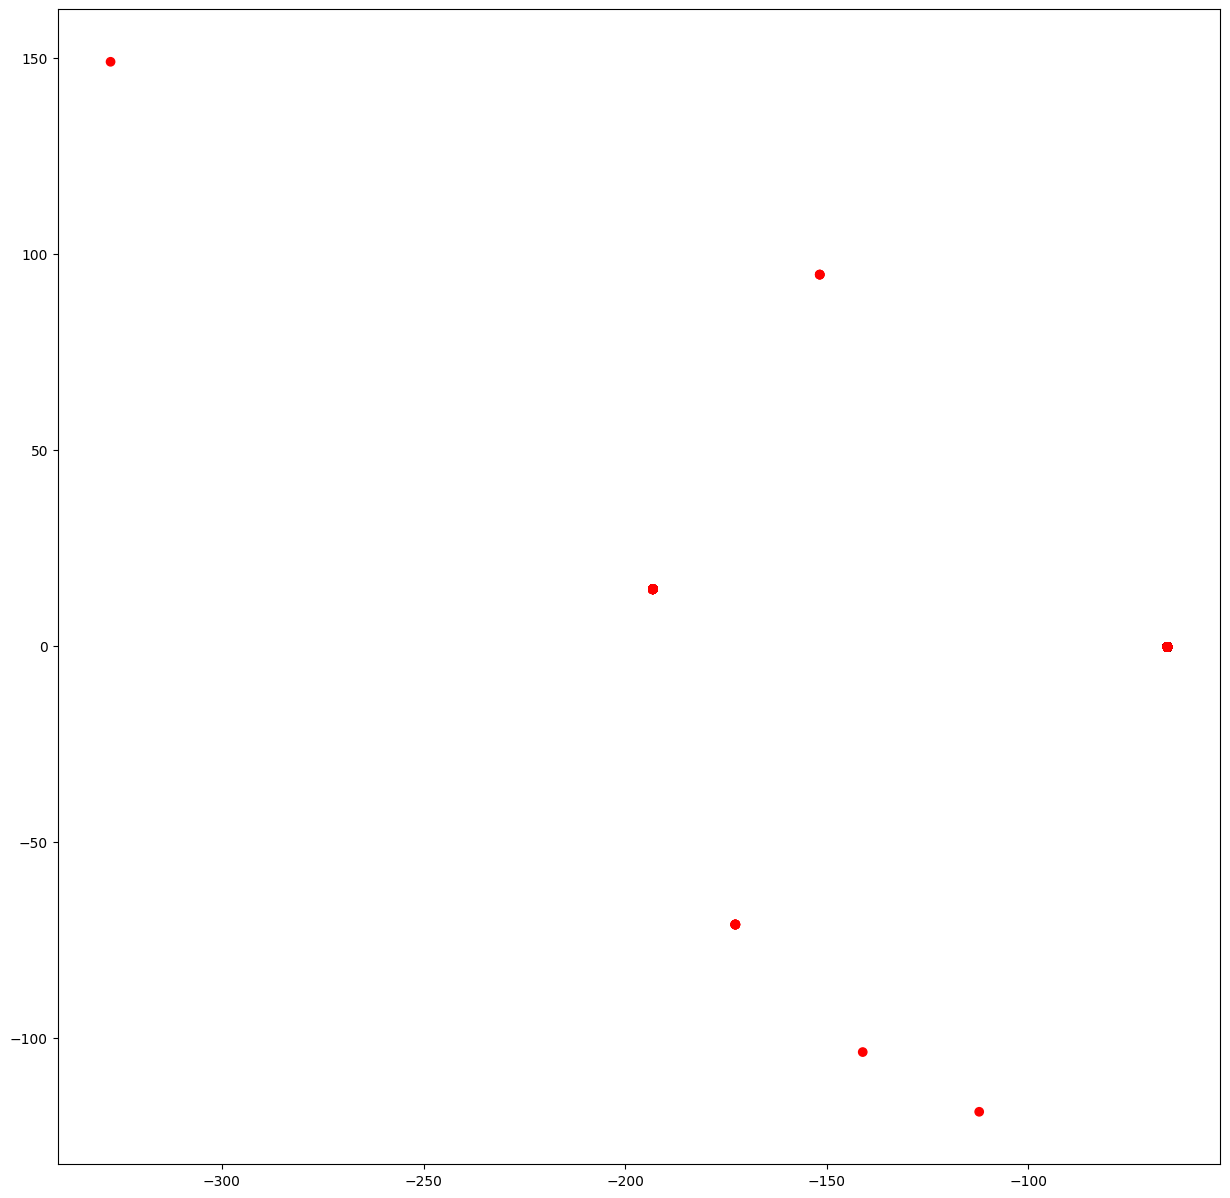

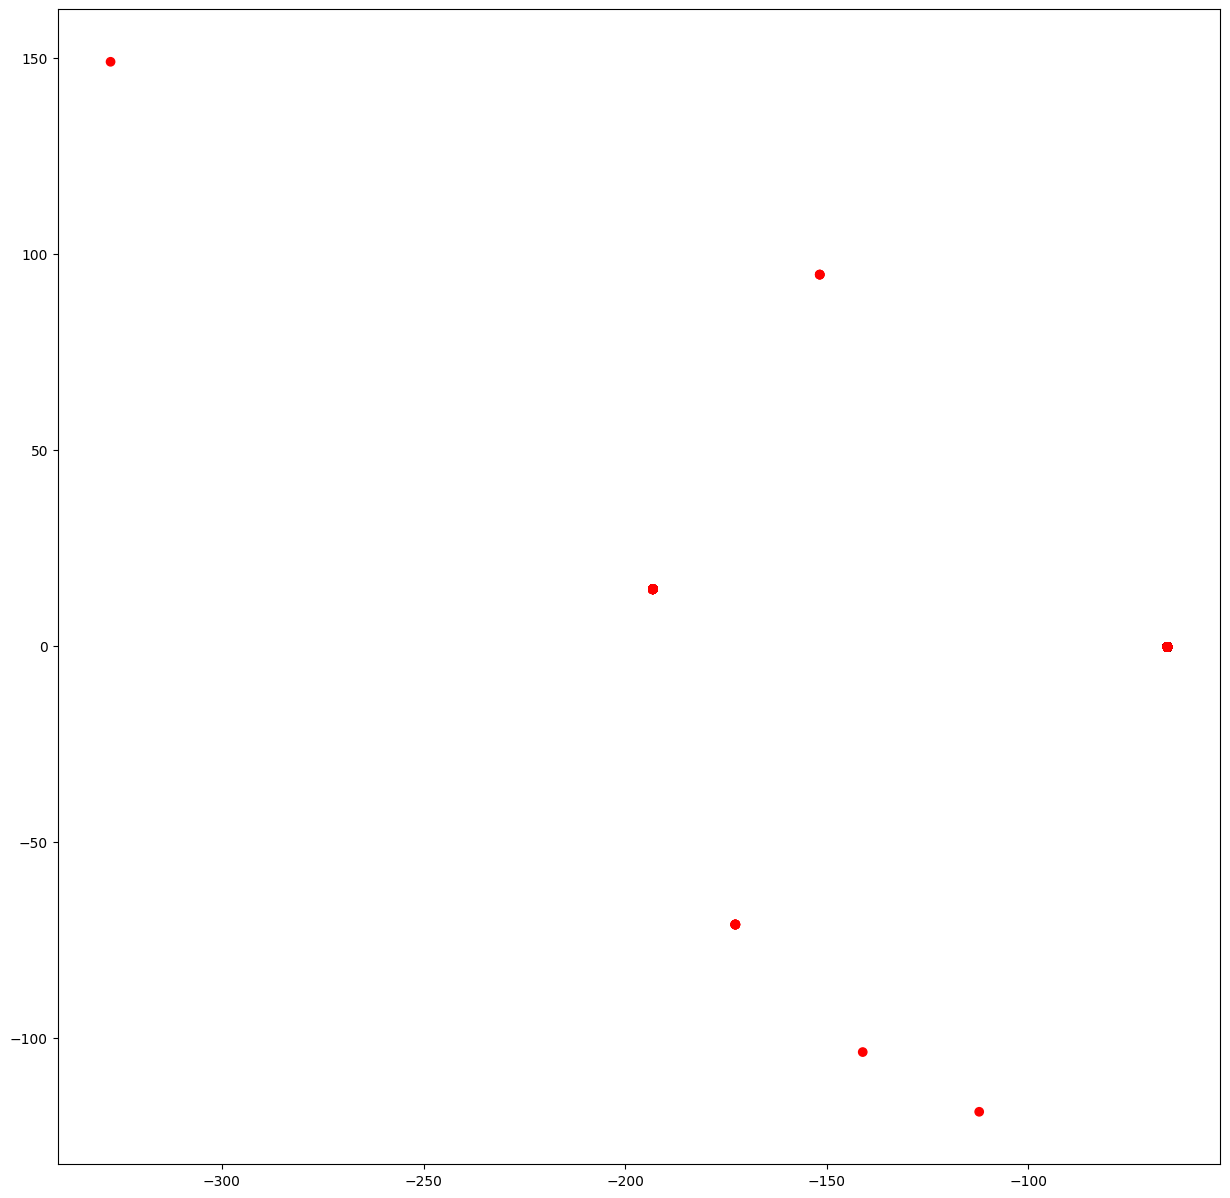

In [69]:

for model_name in crop_results.keys():
    output_tsne_data = get_tsne(outputs)
    plot_representations(output_tsne_data, labels, classes)